In [1]:
import os
import random

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt


import seaborn as sns 
from itertools import product

First we want to establish a baseline energy for our system, given by QuantumJ1J2Solver. This is our energy floor.

In [2]:
from physics.j1j2_solver import QuantumJ1J2Solver
N_PARTICLES = 10
solver = QuantumJ1J2Solver(n_spins=N_PARTICLES, J1=1.0, J2=0.5)
print(f"Exact Ground State Energy: {solver.ground_state_energy}")

Exact Ground State Energy: -3.7500000000000027


In [3]:
def set_seed(seed: int = 123):
    """
    Set random seeds for Python, NumPy and PyTorch
    to make experiments as reproducible as possible.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)

    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Extra flags for more deterministic behaviour on GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"[INFO] Global seed set to {seed}")


Our full training script is below

In [3]:
from train.train_cnn import train_vmc_model
from models.complex_cnn import J1J2ComplexCNNRegressor1D as ComplexCNN
from models.cnn import J1J2CNNRegressor1D as CNN
from utils.plotting import plot_results, plot_j2_comparison
from physics.j1j2_unsupervised import compute_energy_complex_robust, compute_local_energy_log

## Performance at J1=1, J2=0.5, the Majumdar-Ghosh point

Target Exact Energy: -3.7500
Training J1J2CNNRegressor1D...
    Epoch 001 | <E> = -1.2536
Training J1J2ComplexCNNRegressor1D...
    Epoch 001 | <E> = 3.2496

Plot saved to vmc_comparison_robust.png


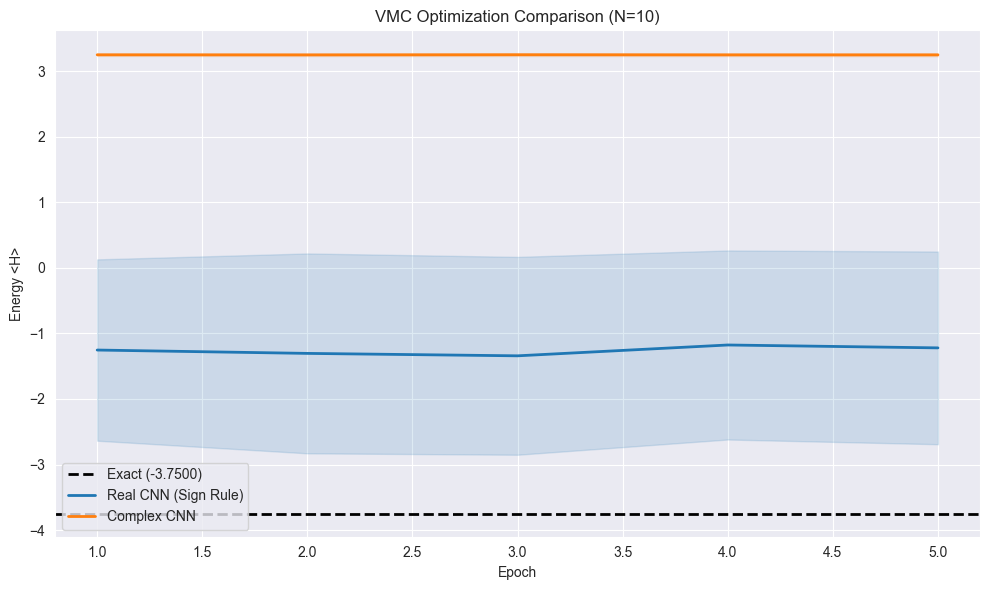

In [4]:
def main():
    config_cnn = {
        'n_spins': 10,
        'J1': 1.0,
        'J2': 0.5,
        'lr': 0.001,
        'n_epochs': 5,
        'depth_1': 16,
        'depth_2': 32,
        'kernel_size': 3,
        'batch_size': 512,
        'mcmc_steps': 10,
        'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
    }
    config_complex = {
        'n_spins': 10,
        'J1': 1.0,
        'J2': 0.5,
        'lr': 0.001,
        'n_epochs': 5,
        'depth_1': 16,
        'depth_2': 32,
        'kernel_size': 3,
        'batch_size': 512,
        'mcmc_steps': 10,
        'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
    }
    
    # 1. Baseline
    solver = QuantumJ1J2Solver(config_cnn['n_spins'], config_cnn['J1'], config_cnn['J2'])
    exact_E = solver.ground_state_energy
    print(f"Target Exact Energy: {exact_E:.4f}")

    results = {}
    
    # 2. Run Experiments
    
    # # Model A: Real CNN + Marshall Sign Rule
    mean_cnn, std_cnn = train_vmc_model(
        CNN, 
        compute_local_energy_log, 
        J2_val=config_cnn['J2'], 
        config=config_cnn
    )
    results["Real CNN (Sign Rule)"] = {'mean': mean_cnn, 'std': std_cnn}
    
    # Model B: Complex Sine MLP (Learns Phase)
    # Using the class defined above as a stand-in for 'SineKAN_NQS'
    mean_complex_cnn, std_complex_cnn = train_vmc_model(
        ComplexCNN, 
        compute_energy_complex_robust, 
        J2_val=config_complex['J2'],
        config=config_complex
    )
    results["Complex CNN"] = {'mean': mean_complex_cnn, 'std': std_complex_cnn}

    # 3. Plot
    plot_results(results, exact_E, config_cnn['n_spins'])

if __name__ == "__main__":
    main()

## Performance across J1, J2 values

Starting Experiments on cpu for N=10...

================ [ J2 = 0.0 ] ================
--> Training Real CNN...
Training J1J2CNNRegressor1D...
    Epoch 001 | <E> = -2.1975
    Final Energy: -2.3851
--> Training Complex CNN...
Training J1J2ComplexCNNRegressor1D...
    Epoch 001 | <E> = 2.2498
    Final Energy: 2.2492

================ [ J2 = 0.5 ] ================
--> Training Real CNN...
Training J1J2CNNRegressor1D...
    Epoch 001 | <E> = -1.2325
    Final Energy: -1.3071
--> Training Complex CNN...
Training J1J2ComplexCNNRegressor1D...
    Epoch 001 | <E> = 3.2493
    Final Energy: 3.2479

================ [ J2 = 1.0 ] ================
--> Training Real CNN...
Training J1J2CNNRegressor1D...
    Epoch 001 | <E> = -0.2203
    Final Energy: -0.3960
--> Training Complex CNN...
Training J1J2ComplexCNNRegressor1D...
    Epoch 001 | <E> = 4.2499
    Final Energy: 4.2505


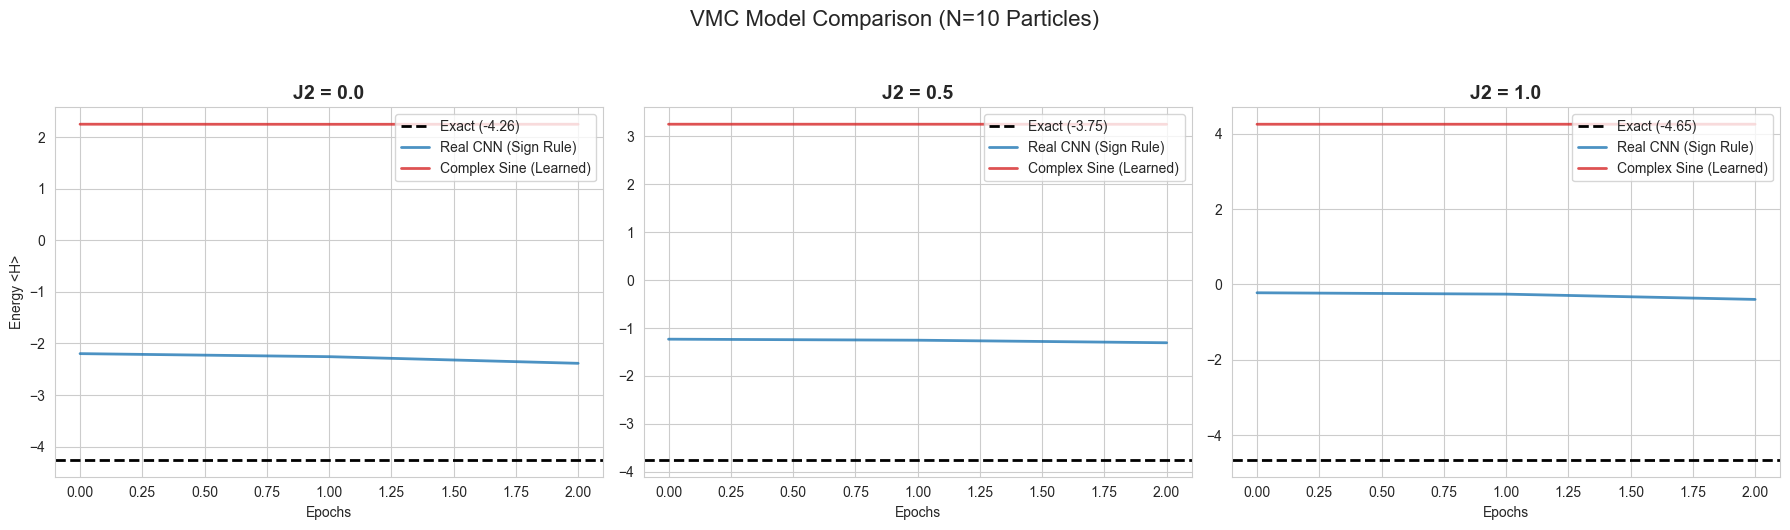

In [6]:
def main():
    config_cnn = {
        'n_spins': 10,  # Fixed at 10
        'J1': 1.0,
        'lr': 0.001,
        'n_epochs': 3,
        'batch_size': 512, 
        'mcmc_steps': 10,
        'depth_1': 16, 
        'depth_2': 32,
        'kernel_size': 3,
        'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
    }

    config_complex = {
        'n_spins': 10,  
        'J1': 1.0,
        'lr': 0.001,
        'n_epochs': 3,
        'batch_size': 512, 
        'mcmc_steps': 10,
        'depth_1': 16, 
        'depth_2': 32,
        'kernel_size': 3,
        'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
    }
    
    J2_list = [0.0, 0.5, 1.0]
    results_store = {}
    
    print(f"Starting Experiments on {config_cnn['device']} for N={config_cnn['n_spins']}...")

    for J2 in J2_list:
        print(f"\n================ [ J2 = {J2} ] ================")
        
        # 1. Get Baseline
        exact_E = QuantumJ1J2Solver(config_cnn['n_spins'], config_cnn['J1'], J2).ground_state_energy
        
        # 2. Train Real CNN (With Sign Rule)
        print("--> Training Real CNN...")
        cnn_hist, _ = train_vmc_model(CNN, compute_local_energy_log, J2, config_cnn)
        print(f"    Final Energy: {cnn_hist[-1]:.4f}")
        
        # 3. Train Complex Sine (Learned Phase)
        print("--> Training Complex CNN...")
        complex_hist, _ = train_vmc_model(ComplexCNN, compute_energy_complex_robust, J2, config_complex)
        print(f"    Final Energy: {complex_hist[-1]:.4f}")
        
        results_store[J2] = {
            'exact': exact_E,
            'cnn': cnn_hist,
            'complexcnn': complex_hist
        }

    # 4. Generate Plot
    plot_j2_comparison(results_store, config_cnn['n_spins'])

if __name__ == "__main__":
    main()